# Предсказание направления цены - Биктоин - Временной интервал 1 час

In [271]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN,ConvLSTM2D, RNN, ConvLSTM1D, ConvLSTM3D
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import keras_tuner
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import cryptocompare

In [243]:
pip install cryptocompare

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.0 MB/s eta 0:00:00


In [272]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})

# Data Collection

In [ ]:
df = []
d1 = datetime(2023,4,24,4)
for i in range(20):
    df_2000 = cryptocompare.get_historical_price_hour('BTC', 'USD', limit=2000, exchange='CCCAGG', toTs=d1)
    df_2000 = pd.DataFrame.from_dict(df_2000)
    df_2000['date'] = pd.to_datetime(df_2000['time'], unit='s')
    df_2000.drop(columns=['time', 'conversionType', 'conversionSymbol'], inplace=True)
    df.append(df_2000)
    d1 = d1 - timedelta(hours=2001)

df = list(reversed(df))
df = pd.concat(df)
df.index = df['date']
df.drop(columns=['date'], inplace=True)
cols = list(df.columns)
a, b = cols.index('high'), cols.index('close')
cols[b], cols[a] = cols[a], cols[b]
OHLCV = df[cols]
OHLCV

,close,low,open,volumefrom,volumeto,high
date,,,,,,
2018-09-29 17:00:00,6594.24,6557.05,6557.16,938.97,6.191449e+06,6596.40
2018-09-29 18:00:00,6584.34,6582.38,6594.38,734.44,4.858345e+06,6603.17
2018-09-29 19:00:00,6582.11,6530.86,6583.76,36130.32,2.378136e+08,6635.33
2018-09-29 20:00:00,6601.13,6587.64,6593.83,1002.04,6.627760e+06,6615.44
2018-09-29 21:00:00,6595.82,6587.41,6601.13,781.52,5.190817e+06,6601.91
...,...,...,...,...,...,...
2023-04-24 00:00:00,27809.21,27439.49,27596.71,1425.85,3.943678e+07,27866.93
2023-04-24 01:00:00,27766.02,27701.37,27809.21,2529.44,7.049334e+07,27989.50
2023-04-24 02:00:00,27747.27,27685.45,27766.02,815.31,2.262972e+07,27832.57


In [ ]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40020 entries, 2018-09-29 17:00:00 to 2023-04-24 04:00:00
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   close       40020 non-null  float64
 1   low         40020 non-null  float64
 2   open        40020 non-null  float64
 3   volumefrom  40020 non-null  float64
 4   volumeto    40020 non-null  float64
 5   high        40020 non-null  float64
dtypes: float64(6)
memory usage: 2.1 MB


In [ ]:
OHLCV.describe()

,close,low,open,volumefrom,volumeto,high
count,40020.000000,40020.000000,40020.000000,40020.000000,4.002000e+04,40020.000000
mean,22521.358834,22403.285628,22520.842338,2102.648282,4.506693e+07,22632.176836
std,16990.744093,16891.923016,16990.923515,3834.491277,1.146225e+08,17083.790436
min,3183.270000,3169.530000,3183.270000,0.291200,1.468160e+03,3198.460000
25%,8723.380000,8684.602500,8723.062500,825.880000,1.021511e+07,8759.550000
50%,17138.165000,17084.700000,17136.920000,1368.230000,2.382903e+07,17166.495000
75%,36157.885000,35869.072500,36157.885000,2343.322500,5.295571e+07,36410.322500
max,68624.180000,68464.620000,68624.180000,235647.610000,7.859574e+09,68978.640000


Bybit

In [273]:
import json 
import requests 
import pandas as pd
import datetime as dt
from time import sleep

In [ ]:
symbol = 'BTCUSDT'

year = 2023
month = 7
day = 12

### Settings Block End   ###


def get_linenumber():
    cf = currentframe()
    global line_number
    line_number = cf.f_back.f_lineno


def get_bybit_bars(symbol, interval, startTime, endTime):

    url = 'https://api.bybit.com/public/linear/kline'
    startTime = str(int(startTime.timestamp()))
    endTime   = str(int(endTime.timestamp()))
    req_params = {'symbol' : symbol, 'interval' : interval, 'from' : startTime, 'to' : endTime}
    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text)['result'])
    if (len(df.index) == 0):
        return None
    
    df.index = [dt.datetime.fromtimestamp(x) for x in df.open_time]
    return df


df_list = []
end_time = dt.datetime(year, month, day)
delta = dt.timedelta(hours=200)
start_time = end_time - delta

for i in range(200):
    new_df = get_bybit_bars(symbol, 60, start_time, end_time)
    df_list = [new_df] + df_list
    end_time = start_time
    start_time = end_time - delta 
    
df = pd.concat(df_list)
OHLCV = df[['open','high','low','close']]
print(OHLCV)

In [ ]:
OHLCV.info()

In [ ]:
OHLCV.describe()

In [ ]:
plt.plot(OHLCV['close'])

# Data prepocessing

Преобразуем наш датасет. Попробуем предоставить модели полную картину, происходящую на графике биржи, которые видят трейдеры, прогнозирующие цену с помощью технического анализа. Наш датасет будет состоять из следующих данных:

close - цена закрытия свечи;

low - цена низшей точки свечи;

high - цена высшей точки свечи;

open - цена открытия свечи;

close_diff - разница между ценами закрытия соседних свечей;

low_diff - разница между ценами низших точек соседних свечей;

high_diff - разница между ценами высших точек соседних свечей;

open_diff - разница между ценами открытия соседних свечей;

color_of_candle - цвет свечи(красный или зеленый, красный цвет - цена закрытия свечи ниже цены открытия, зеленый цвет - цена закрытия свечи выше цены открытия)

number_candle_trend - порядковый номер свечи в тренде(обозначает порядковый номер свечи в последовательности свечей одинакового цвета)

SMA_200 - 200-часовая скользящая средняя

EMA_200 - 200-часовая скользящая экспоненциальная

SMA_50 - 50-часовая скользящая средняя

EMA_50 - 50-часовая скользящая экспоненциальная

RSI - индекс относительной силы

MACD - линия MACD, является результатом взятия более долгосрочной EMA и вычитания ее из более краткосрочной EMA.Наиболее часто используемые значения - 26 часов для долгосрочной EMA и 12 часов для краткосрочной EMA

Signal - Сигнальная линия представляет собой EMA линии MACD, описанной в MACD. Трейдер может выбрать, какую EMA длины периода использовать для сигнальной линии, однако 9 является наиболее распространенной.

Histogram - С течением времени разница между линией MACD и сигнальной линией будет постоянно меняться. Гистограмма MACD учитывает это различие и отображает его в виде легко читаемой гистограммы. Разница между двумя линиями колеблется вокруг нулевой линии.

width_open_close - разница между ценой открытия и закрытия свечи

width_open_high - разница между ценой открытия и высшей ценой свечи

width_open_low - разница между ценой открытия и низшей ценой свечи

In [ ]:
columns = {}
columns['close'] = list(OHLCV['close'].values)

SMA и EMA

In [ ]:
SMA_200 = OHLCV['close'].rolling(window = 200).mean()
EMA_200 = OHLCV['close'].ewm(span=200).mean()
SMA_50 = OHLCV['close'].rolling(window = 50).mean()
EMA_50 = OHLCV['close'].ewm(span=50).mean()

SMA_200 = SMA_200.dropna()
EMA_200 = EMA_200.dropna()
SMA_50 = SMA_50.dropna()
EMA_50 = EMA_50.dropna()

columns['SMA_200'] = list(SMA_200.values)
columns['EMA_200'] = list(EMA_200.values)
columns['SMA_50'] = list(SMA_50.values)
columns['EMA_50'] = list(EMA_50.values)

RSI

In [ ]:
def calculate_rsi(data, window=14):
    close = data['close']
    delta = close.diff()
    delta = delta[1:]

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window).mean()
    roll_down = np.abs(down.rolling(window).mean())

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

rsi = calculate_rsi(OHLCV)
rsi = rsi.dropna()
rsi

In [ ]:
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(rsi, label='RSI', color = 'blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
columns['RSI'] = list(rsi.values)

MACD

In [ ]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    close = data['close']
    exp1 = close.ewm(span=fast, min_periods=fast).mean()
    exp2 = close.ewm(span=slow, min_periods=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

macd, signal_line, histogram = calculate_macd(OHLCV)

plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(OHLCV.index, macd, label='FB MACD', color = 'blue')
plt.plot(OHLCV.index, signal_line, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [ ]:
macd = macd.dropna()
signal_line = signal_line.dropna()
histogram = histogram.dropna()

columns['macd'] = list(macd.values)
columns['signal_line'] = list(signal_line.values)
columns['histogram'] = list(histogram.values)

close_diff low_diff open_diff high_diff

In [ ]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return diff
# df1 = df[1:]
def difference_for_every_column(df, df1): 
    for column in df.columns.values:
        diff = difference(df[column])
        df1[column+'_diff'] = diff
    return df1

In [ ]:
diff_df = pd.DataFrame()
diff_df = difference_for_every_column(OHLCV[['close', 'low', 'open', 'high']] , diff_df) 
diff_df  

In [ ]:
columns['close_diff'] = list(diff_df['close_diff'].values)
columns['low_diff'] = list(diff_df['low_diff'].values)
columns['open_diff'] = list(diff_df['open_diff'].values)
columns['high_diff'] = list(diff_df['high_diff'].values)

width_open_close, width_open_high, width_open_low

In [ ]:
close_values = OHLCV['close'].values
low_values = OHLCV['low'].values
open_values = OHLCV['open'].values
high_values = OHLCV['high'].values
width_open_close = np.zeros(shape= len(OHLCV))
width_open_high = np.zeros(shape=len(OHLCV))
width_open_low = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    width_open_close[i] = close_values[i] - open_values[i] 
    width_open_high[i] = high_values[i] - open_values[i]
    width_open_low[i] = open_values[i] - low_values[i]

columns['width_open_close'] = list(width_open_close)
columns['width_open_high'] = list(width_open_high)
columns['width_open_low'] = list(width_open_low)

color_of_candle, number_candle_trend

In [ ]:
color_of_candle = []
number_candle_trend = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    if width_open_close[i] > 0:
        color_of_candle.append('green')
    else:
        color_of_candle.append('red')
        
number_candle_trend[0] = 1
cnt = 1
for i in range(1,len(OHLCV)):
    if (color_of_candle[i] == color_of_candle[i - 1]):
        cnt = cnt + 1
        number_candle_trend[i] = cnt
    else:
        cnt = 1
        number_candle_trend[i] = cnt

columns['color_of_candle'] = color_of_candle
columns['number_candle_trend'] = number_candle_trend

Соберем все признаки в один датасет

In [ ]:
for key, value in columns.items():
    print(key, " -> ", len(value))

In [ ]:
df_candles = pd.DataFrame({})
for key, value in columns.items():
    df_candles[key] = value[-(len(SMA_200)):]
    
df_candles

In [ ]:
percent = []
for index, row in df_candles.iterrows():
    percent.append(abs(row['close_diff'])/row['close'])

change_percent_mean = np.array(percent).mean()

In [ ]:
#делаем сдвиг по целевой переменной, чтобы для каждой строки целевой переменной стало значения закрытия цены на следующей свече
df_close_next = df_candles['close'][1:].values
df_candles = df_candles[:-1]
df_candles['close_next'] = df_close_next
df_candles

In [ ]:
df_candles_supervised = df_candles.copy()
directions = []
for index, row in df_candles_supervised.iterrows():
    if row['close_next'] > row['close']:
        directions.append('long')
    else:
        directions.append('short')
df_candles_supervised['direction'] = directions
df_candles_supervised  

Кодируем категориальные переменнные

In [ ]:


number_candle_trend_encoder = LabelEncoder()
df_candles_supervised["color_of_candle"] = number_candle_trend_encoder.fit_transform(df_candles_supervised["color_of_candle"])
color_of_candle_encoder = LabelEncoder()
df_candles_supervised["number_candle_trend"] = color_of_candle_encoder.fit_transform(df_candles_supervised["number_candle_trend"])
direction_encoder = LabelEncoder()
df_candles_supervised["direction"] = direction_encoder.fit_transform(df_candles_supervised["direction"])

df_candles_supervised.drop(columns = ['close_next'], inplace = True)

In [ ]:
df_candles_supervised['direction'].value_counts()

In [ ]:
df_candles_supervised

In [ ]:
df_candles_supervised.info()

Преобразованный датасет имеет 39820 строк и 19 колонок

# Feature Selection

Определим наилучший метод для отбора признаков

Функция разбиения датасета и нормализации

In [270]:
def split_normalization_for_VIF_RFE_PCA(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]    
    
    scaler_1 = MinMaxScaler(feature_range = (0,1))
    scaler_2 = MinMaxScaler(feature_range = (-1,1))
    
    
    #scaler_1
    features_scaler_1 = []


    #scaler_2
    features_scaler_2 = []

    
    columns_dataset = list(dataset.columns.values)
    columns_dataset.remove('color_of_candle')
    columns_dataset.remove('number_candle_trend')
    columns_dataset.remove('direction')

    for column in columns_dataset:
        if any(x < 0 for x in list(dataset[column].values)):
            features_scaler_2.append(column)
        else:
            features_scaler_1.append(column)
    
    

    # train

    train_1 = train.loc[:, features_scaler_1].values
    train_2 = train.loc[:, features_scaler_2].values


    train_1 = scaler_1.fit_transform(train_1)
    train_1 = pd.DataFrame(train_1, columns=features_scaler_1)

    train_2 = scaler_2.fit_transform(train_2)
    train_2 = pd.DataFrame(train_2, columns=features_scaler_2)

    train_categorial = train.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    train_std = pd.concat([train_1, train_2, train_categorial], axis=1)
    
    # test
    test_1 = test.loc[:, features_scaler_1].values
    test_2 = test.loc[:, features_scaler_2].values


    test_1 = scaler_1.transform(test_1)
    test_1 = pd.DataFrame(test_1, columns=features_scaler_1)

    test_2 = scaler_2.transform(test_2)
    test_2 = pd.DataFrame(test_2, columns=features_scaler_2)

    test_categorial = test.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    test_std = pd.concat([test_1, test_2, test_categorial], axis=1)
    
    # val
    val_1 = val.loc[:, features_scaler_1].values
    val_2 = val.loc[:, features_scaler_2].values


    val_1 = scaler_1.transform(val_1)
    val_1 = pd.DataFrame(val_1, columns=features_scaler_1)

    val_2 = scaler_2.transform(val_2)
    val_2 = pd.DataFrame(val_2, columns=features_scaler_2)

    val_categorial = val.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    val_std = pd.concat([val_1, val_2, val_categorial], axis=1)



    train_X = train_std.drop(['direction', 'index'],axis=1)
    train_y = train_std['direction']
    
    test_X = test_std.drop(['direction', 'index'],axis=1)
    test_y = test_std['direction']


    val_X = val_std.drop(['direction', 'index'],axis=1)
    val_y = val_std['direction']

    return train_X, train_y, test_X, test_y, val_X, val_y

Функция создания последовательностей

In [29]:
# multivariate output data prep
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(df, n_steps):

    columns = df.columns.values

    arrays = []
    for column in columns:
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

Метрики

In [44]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def count_money(real, forecast, close):
    profit = 0
    for i in range(len(real) - 1):
        if (real[i] == forecast[i]):
            profit = profit + abs(close[i] - close[i+1])
        else:
            profit = profit - abs(close[i] - close[i+1])
    return profit


def metrics(real, forecast):
    
    print('balanced_accuracy:', balanced_accuracy_score(real, forecast))
    print('precision:', precision_score(real, forecast))
    print('recall:', recall_score(real, forecast))
    print('f1-score:', f1_score(real, forecast))
    cm = confusion_matrix(real, forecast)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

VIF

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_creation(X):
    vif_df = pd.DataFrame()
    vif_df['Feature Name'] = X.columns
    vif_df['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

vif_df = df_candles_supervised.drop(['direction'], axis =1)
vif_df = vif_creation(vif_df)
vif_df

,Feature Name,Vif Factor
0,close,6.243859e+04
1,SMA_200,1.066186e+04
2,EMA_200,1.382720e+04
3,SMA_50,1.018523e+05
4,EMA_50,1.649606e+05
5,RSI,3.913639e+00
6,macd,inf
7,signal_line,inf
8,histogram,inf
9,close_diff,1.116823e+02


Выберем признаки со значением меньше 6

In [33]:
columns_vif = []
for index, row in vif_df.iterrows():
    if (row['Vif Factor'] < 5):
      columns_vif.append(row['Feature Name'])

columns_vif.append('direction')


df_candles_VIF = df_candles_supervised[columns_vif]

df_candles_VIF


,RSI,low_diff,open_diff,high_diff,color_of_candle,number_candle_trend,direction
0,91.315563,126.0,112.0,319.5,0,3,1
1,50.000000,-408.5,-408.5,-639.0,0,4,1
2,46.096162,-42.5,91.5,37.0,1,0,0
3,47.911338,44.5,-80.0,-40.0,0,0,0
4,47.665953,60.0,72.0,157.0,0,1,0
...,...,...,...,...,...,...,...
39795,42.417948,19.6,37.3,-15.2,1,0,1
39796,39.361702,-11.0,-1.0,-4.6,1,1,0
39797,38.682766,24.4,-2.1,97.2,0,0,1
39798,46.986667,28.6,45.4,-45.1,1,0,1


In [34]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_VIF)

n_steps = 10
Train_X_sq = split_sequences(train_X, n_steps)
Test_X_sq = split_sequences(test_X, n_steps)
Val_X_sq = split_sequences(val_X, n_steps)


train_y_sq = train_y[n_steps - 1: -1]
val_y_sq = val_y[n_steps - 1: -1]
test_y_sq = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_sq.shape[1], Train_X_sq.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_sq, train_y_sq, batch_size=72, epochs=20, validation_data=(Val_X_sq, val_y_sq), callbacks = [callback])

yhat = model.predict(Test_X_sq)
yhat = yhat.reshape(yhat.shape[0])

for i in range(len(yhat)):
    if (yhat[i]>0.5):
        yhat[i] = 1
    else:
        yhat[i] = 0
        
metrics(yhat, test_y_sq)


Epoch 1/20
 17/354 [>.............................] - ETA: 20s - loss: 0.6941 - binary_accuracy: 0.5163

KeyboardInterrupt: 

In [39]:
index_test = len(train_X) + len(val_X)
print(len(test_X), len(df_candles_supervised['close'].values[index_test:]))

7960 7960


balanced_accuracy: 0.542806145371608
precision: 0.38508217446270543
recall: 0.553214674900109
f1-score: 0.45408467501490757


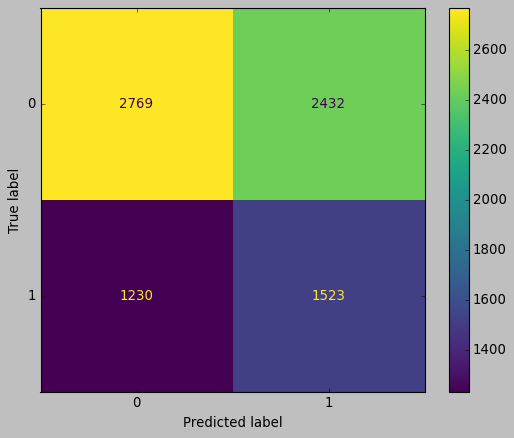

In [ ]:
metrics(yhat, test_y_sq)

RFE

In [62]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_RFE={}
Train_yhat_metrics_RFE['balanced_acc'] = []
Train_yhat_metrics_RFE['precision'] = []
Train_yhat_metrics_RFE['recall'] = []
Train_yhat_metrics_RFE['count_money'] = []

Test_yhat_metrics_RFE={}
Test_yhat_metrics_RFE['balanced_acc'] = []
Test_yhat_metrics_RFE['precision'] = []
Test_yhat_metrics_RFE['recall'] = []
Test_yhat_metrics_RFE['count_money'] = []
 
m=train_X.shape[1]-1

features_rfe = []

for i in range(m):

    train_y_1 = train_y.copy()
    
    rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-i)            
    rfe = rfe.fit(train_X, train_y_1)
    
    Train_X_std_rfe = train_X.loc[:,rfe.support_]
    Test_X_std_rfe = test_X.loc[:,rfe.support_]
    Val_X_std_rfe = val_X.loc[:,rfe.support_]
    
    features_rfe.append(rfe.support_)
    
    n_steps = 10
    Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
    Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
    Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


    train_y_rfe = train_y[n_steps - 1: -1]
    val_y_rfe = val_y[n_steps - 1: -1]
    test_y_rfe = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(128, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
    model.add(LSTM(56, activation = 'relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
    model.fit(Train_X_std_rfe, train_y_rfe, batch_size=36, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_rfe)
    yhat_test = model.predict(Test_X_std_rfe)
    yhat_train = yhat_train.reshape(yhat_train.shape[0])
    yhat_test = yhat_test.reshape(yhat_test.shape[0])

    for i in range(len(yhat_train)):
        if (yhat_train[i]>0.5):
            yhat_train[i] = 1
        else:
            yhat_train[i] = 0

    for i in range(len(yhat_test)):
        if (yhat_test[i]>0.5):
            yhat_test[i] = 1
        else:
            yhat_test[i] = 0

    Train_yhat_metrics_RFE['balanced_acc'].append(balanced_accuracy_score(yhat_train, train_y_rfe.values))
    Train_yhat_metrics_RFE['precision'].append(precision_score(yhat_train, train_y_rfe.values))
    Train_yhat_metrics_RFE['recall'].append(recall_score(yhat_train, train_y_rfe.values))
    Train_yhat_metrics_RFE['count_money'].append(count_money(yhat_train, train_y_rfe.values, 
                                            df_candles_supervised['close'].values[:len(yhat_train)]))


    Test_yhat_metrics_RFE['balanced_acc'].append(balanced_accuracy_score(yhat_test, test_y_rfe.values))
    Test_yhat_metrics_RFE['precision'].append(precision_score(yhat_test, test_y_rfe.values))
    Test_yhat_metrics_RFE['recall'].append(recall_score(yhat_test, test_y_rfe.values))
    Test_yhat_metrics_RFE['count_money'].append(count_money(yhat_test, test_y_rfe.values, 
                                            df_candles_supervised['close'].values[(len(train_X) + len(val_X) + 10):]))

    
    


Epoch 1/20
708/708 [==============================] - 16s 17ms/step - loss: 0.6921 - binary_accuracy: 0.5150 - val_loss: 0.6967 - val_binary_accuracy: 0.5107
Epoch 2/20
708/708 [==============================] - 12s 16ms/step - loss: 0.6821 - binary_accuracy: 0.5488 - val_loss: 0.6934 - val_binary_accuracy: 0.5203
Epoch 3/20
708/708 [==============================] - 12s 16ms/step - loss: 0.6542 - binary_accuracy: 0.5836 - val_loss: 0.6966 - val_binary_accuracy: 0.5066
Epoch 4/20
708/708 [==============================] - 12s 16ms/step - loss: 0.6063 - binary_accuracy: 0.6241 - val_loss: 0.6957 - val_binary_accuracy: 0.5036
Epoch 5/20
708/708 [==============================] - 12s 16ms/step - loss: 0.5360 - binary_accuracy: 0.6699 - val_loss: 0.6924 - val_binary_accuracy: 0.5217
Epoch 6/20
708/708 [==============================] - 12s 16ms/step - loss: 0.4795 - binary_accuracy: 0.7038 - val_loss: 0.6945 - val_binary_accuracy: 0.5132
Epoch 7/20
708/708 [==============================] 

708/708 [==============================] - 19s 21ms/step - loss: 0.6923 - binary_accuracy: 0.5134 - val_loss: 0.6932 - val_binary_accuracy: 0.4967
Epoch 2/20
708/708 [==============================] - 14s 20ms/step - loss: 0.6868 - binary_accuracy: 0.5245 - val_loss: 0.6943 - val_binary_accuracy: 0.4991
Epoch 3/20
708/708 [==============================] - 14s 20ms/step - loss: 0.6855 - binary_accuracy: 0.5293 - val_loss: 0.6933 - val_binary_accuracy: 0.4942
Epoch 4/20
708/708 [==============================] - 14s 20ms/step - loss: 0.6797 - binary_accuracy: 0.5424 - val_loss: 0.6936 - val_binary_accuracy: 0.5074
Epoch 5/20
708/708 [==============================] - 14s 20ms/step - loss: 0.6751 - binary_accuracy: 0.5473 - val_loss: 0.6938 - val_binary_accuracy: 0.4978
Epoch 6/20
708/708 [==============================] - 19s 26ms/step - loss: 0.6679 - binary_accuracy: 0.5536 - val_loss: 0.6930 - val_binary_accuracy: 0.5153
Epoch 7/20
708/708 [==============================] - 15s 21ms/

708/708 [==============================] - 14s 20ms/step - loss: 0.7235 - binary_accuracy: 0.5115 - val_loss: 0.6927 - val_binary_accuracy: 0.5288
Epoch 3/20
708/708 [==============================] - 14s 20ms/step - loss: 0.7092 - binary_accuracy: 0.5180 - val_loss: 0.6937 - val_binary_accuracy: 0.4947
Epoch 4/20
708/708 [==============================] - 14s 20ms/step - loss: 0.7022 - binary_accuracy: 0.5217 - val_loss: 0.6922 - val_binary_accuracy: 0.5170
Epoch 5/20
249/249 [==============================] - 2s 7ms/step
Epoch 1/20
708/708 [==============================] - 18s 21ms/step - loss: 0.6929 - binary_accuracy: 0.5119 - val_loss: 0.6930 - val_binary_accuracy: 0.5053
Epoch 2/20
708/708 [==============================] - 14s 19ms/step - loss: 0.6932 - binary_accuracy: 0.5179 - val_loss: 0.6930 - val_binary_accuracy: 0.5233
Epoch 3/20
708/708 [==============================] - 14s 20ms/step - loss: 0.7367 - binary_accuracy: 0.5135 - val_loss: 0.6930 - val_binary_accuracy: 0.50

708/708 [==============================] - 15s 21ms/step - loss: 0.6869 - binary_accuracy: 0.5376 - val_loss: 0.7089 - val_binary_accuracy: 0.5195
Epoch 11/20
708/708 [==============================] - 15s 21ms/step - loss: 0.6847 - binary_accuracy: 0.5478 - val_loss: 0.6916 - val_binary_accuracy: 0.5357
Epoch 12/20
708/708 [==============================] - 15s 21ms/step - loss: 0.6803 - binary_accuracy: 0.5547 - val_loss: 0.7168 - val_binary_accuracy: 0.5253
Epoch 13/20
708/708 [==============================] - 15s 21ms/step - loss: 0.6762 - binary_accuracy: 0.5589 - val_loss: 0.6955 - val_binary_accuracy: 0.5223
Epoch 14/20
249/249 [==============================] - 2s 7ms/step


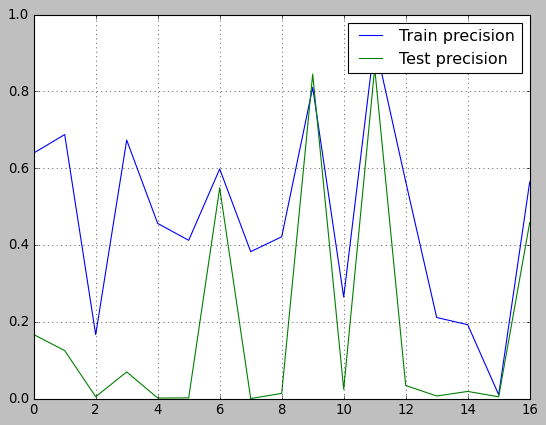

In [63]:
plt.plot(Train_yhat_metrics_RFE['precision'], label='Train precision')
plt.plot(Test_yhat_metrics_RFE['precision'], label='Test precision')
plt.legend()
plt.grid()
plt.show()

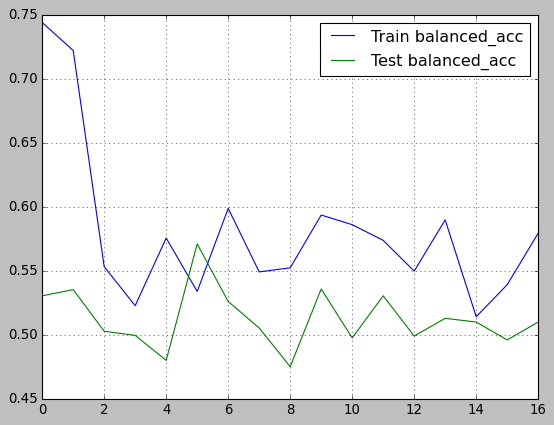

In [64]:
plt.plot(Train_yhat_metrics_RFE['balanced_acc'], label='Train balanced_acc')
plt.plot(Test_yhat_metrics_RFE['balanced_acc'], label='Test balanced_acc')
plt.legend()
plt.grid()
plt.show()

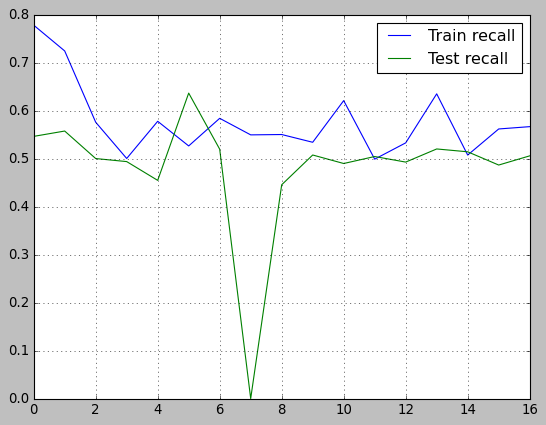

In [65]:
plt.plot(Train_yhat_metrics_RFE['recall'], label='Train recall')
plt.plot(Test_yhat_metrics_RFE['recall'], label='Test recall')
plt.legend()
plt.grid()
plt.show()

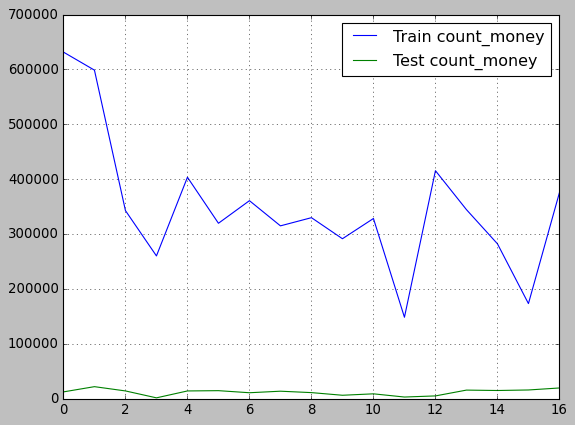

In [66]:
plt.plot(Train_yhat_metrics_RFE['count_money'], label='Train count_money')
plt.plot(Test_yhat_metrics_RFE['count_money'], label='Test count_money')
plt.legend()
plt.grid()
plt.show()

In [67]:
Test_yhat_metrics_RFE['count_money']

[12150.100000000093,
 21684.1,
 13901.700000000128,
 1302.1000000001004,
 13865.50000000016,
 14389.90000000014,
 10609.09999999981,
 13399.100000000151,
 10834.300000000134,
 6013.699999999786,
 8612.700000000143,
 2776.6999999997934,
 4823.100000000144,
 15410.100000000166,
 14682.700000000143,
 15644.700000000143,
 19296.699999999946]

Сравнив все показатели самым лучшим показателем будет число 1 для RFE

Epoch 1/20
708/708 [==============================] - 46s 54ms/step - loss: 0.6897 - binary_accuracy: 0.5218 - val_loss: 0.6929 - val_binary_accuracy: 0.5151
Epoch 2/20
708/708 [==============================] - 34s 48ms/step - loss: 0.6807 - binary_accuracy: 0.5520 - val_loss: 0.6922 - val_binary_accuracy: 0.5193
Epoch 3/20
708/708 [==============================] - 33s 46ms/step - loss: 0.6701 - binary_accuracy: 0.5661 - val_loss: 0.6923 - val_binary_accuracy: 0.5157
Epoch 4/20
708/708 [==============================] - 32s 46ms/step - loss: 0.6520 - binary_accuracy: 0.5857 - val_loss: 0.6997 - val_binary_accuracy: 0.4992
Epoch 5/20
249/249 [==============================] - 2s 10ms/step
balanced_accuracy: 0.5095923499697195
precision: 0.5490753911806543
recall: 0.09811896288764616
f1-score: 0.16648695277118825


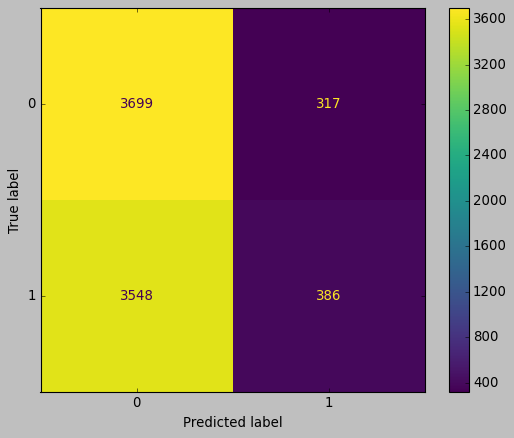

In [208]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)

rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-1)            
rfe = rfe.fit(train_X, train_y)

Train_X_std_rfe = train_X.loc[:,rfe.support_]
Test_X_std_rfe = test_X.loc[:,rfe.support_]
Val_X_std_rfe = val_X.loc[:,rfe.support_]


n_steps = 10
Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


train_y_rfe = train_y[n_steps - 1: -1]
val_y_rfe = val_y[n_steps - 1: -1]
test_y_rfe = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(128, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_std_rfe, train_y_rfe, batch_size=36, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_rfe)
yhat_test = model.predict(Test_X_std_rfe)

yhat_train = model.predict(Train_X_std_rfe)
yhat_test = model.predict(Test_X_std_rfe)
yhat_train = yhat_train.reshape(yhat_train.shape[0])
yhat_test = yhat_test.reshape(yhat_test.shape[0])

for i in range(len(yhat_train)):
    if (yhat_train[i]>0.5):
        yhat_train[i] = 1
    else:
        yhat_train[i] = 0

for i in range(len(yhat_test)):
    if (yhat_test[i]>0.5):
        yhat_test[i] = 1
    else:
        yhat_test[i] = 0

metrics(test_y_rfe, yhat_test)

In [209]:
pd.Series(list(yhat_test)).value_counts()

0.0    7247
1.0     703
dtype: int64

In [210]:
pd.Series(test_y_rfe).value_counts()

0    4016
1    3934
Name: direction, dtype: int64

In [73]:
count_money(test_y_rfe.values, yhat_test,  
                                            df_candles_supervised['close'].values[(len(train_X) + len(val_X) + 10):])

12266.299999999996

In [77]:
money = {}
j = 0 
interval = 24 * 7
close = df_candles_supervised['close'].values[(len(train_X) + len(val_X) + 10):]
for i in range(len(test_y_rfe) // interval):
    count_money_100 = count_money(test_y_rfe.values[j:j+interval], yhat_test[j:j+interval], close[j:j+interval])
    money[i] = count_money_100
    j = j + interval
    print(i,' : ',count_money_100)

0  :  -2227.0
1  :  540.5
2  :  408.0
3  :  1224.0
4  :  2525.5
5  :  1811.0
6  :  1415.5
7  :  257.5
8  :  383.0
9  :  -647.0
10  :  -134.5
11  :  -460.0
12  :  620.5
13  :  -731.0
14  :  185.0
15  :  952.5
16  :  -137.5
17  :  273.5
18  :  -169.5
19  :  217.5
20  :  14.5
21  :  -699.5
22  :  272.0
23  :  -2082.5
24  :  52.5
25  :  -210.5
26  :  -593.700000000008
27  :  -824.5000000000109
28  :  3089.900000000038
29  :  666.3000000000029
30  :  -1864.5999999999913
31  :  4456.199999999993
32  :  678.9000000000196
33  :  1949.5
34  :  759.099999999984
35  :  384.700000000008
36  :  50.10000000000946
37  :  1533.899999999976
38  :  -967.6000000000131
39  :  -325.1000000000131
40  :  -330.20000000000437
41  :  -587.8000000000102
42  :  -872.6999999999935
43  :  -10.799999999995634
44  :  308.3999999999978
45  :  1758.9000000000087
46  :  -1468.5


PCA

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_PCA={}
Train_yhat_metrics_PCA['balanced_acc'] = []
Train_yhat_metrics_PCA['precision'] = []
Train_yhat_metrics_PCA['recall'] = []

Test_yhat_metrics_PCA={}
Test_yhat_metrics_PCA['balanced_acc'] = []
Test_yhat_metrics_PCA['precision'] = []
Test_yhat_metrics_PCA['recall'] = []
 
m=train_X.shape[1]-1

features_pca = []

for i in range(m):
    
    pca = PCA(n_components=train_X.shape[1]-i)           
    
    Train_X_std_pca = pca.fit_transform(train_X)
    Val_X_std_pca = pca.fit_transform(val_X)
    Test_X_std_pca = pca.fit_transform(test_X)
    
    
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    Val_X_std_pca = pd.DataFrame(Val_X_std_pca)


    n_steps = 10
    Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
    Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
    Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)

    train_y_pca = train_y[n_steps - 1: -1]
    val_y_pca = val_y[n_steps - 1: -1]
    test_y_pca = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
    model.add(LSTM(128, activation = 'elu',return_sequences=True))
    model.add(LSTM(56, activation = 'elu'))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
    # fit network

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
    model.fit(Train_X_std_pca, train_y_pca, batch_size=72, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_pca)
    yhat_test = model.predict(Test_X_std_pca)

    for i in range(len(yhat_train)):
        if (yhat_train[i]>0.5):
            yhat_train[i] = 1
        else:
            yhat_train[i] = 0

    for i in range(len(yhat_test)):
        if (yhat_test[i]>0.5):
            yhat_test[i] = 1
        else:
            yhat_test[i] = 0

    Train_yhat_metrics_PCA['balanced_acc'].append(balanced_accuracy_score(yhat_train, train_y_pca))
    Train_yhat_metrics_PCA['precision'].append(precision_score(yhat_train, train_y_pca))
    Train_yhat_metrics_PCA['recall'].append(recall_score(yhat_train, train_y_pca))


    Test_yhat_metrics_PCA['balanced_acc'].append(balanced_accuracy_score(yhat_test, test_y_pca))
    Test_yhat_metrics_PCA['precision'].append(precision_score(yhat_test, test_y_pca))
    Test_yhat_metrics_PCA['recall'].append(recall_score(yhat_test, test_y_pca))

Epoch 1/20
710/710 [==============================] - 140s 183ms/step - loss: 0.7711 - binary_accuracy: 0.5238 - val_loss: 0.9285 - val_binary_accuracy: 0.5001
Epoch 2/20
710/710 [==============================] - 108s 152ms/step - loss: 0.6892 - binary_accuracy: 0.5392 - val_loss: 0.8826 - val_binary_accuracy: 0.4950
Epoch 3/20
710/710 [==============================] - 119s 167ms/step - loss: 0.6880 - binary_accuracy: 0.5452 - val_loss: 0.8813 - val_binary_accuracy: 0.5067
Epoch 4/20
710/710 [==============================] - 119s 167ms/step - loss: 0.6879 - binary_accuracy: 0.5458 - val_loss: 0.7854 - val_binary_accuracy: 0.5009
Epoch 5/20
710/710 [==============================] - 118s 167ms/step - loss: 0.6874 - binary_accuracy: 0.5505 - val_loss: 0.8277 - val_binary_accuracy: 0.4953
Epoch 6/20
499/499 [==============================] - 20s 39ms/step
Epoch 1/20
710/710 [==============================] - 135s 177ms/step - loss: 0.7129 - binary_accuracy: 0.5237 - val_loss: 0.8059 - 

499/499 [==============================] - 20s 39ms/step
Epoch 1/20
710/710 [==============================] - 132s 173ms/step - loss: 0.7237 - binary_accuracy: 0.5260 - val_loss: 0.8684 - val_binary_accuracy: 0.4980
Epoch 2/20
710/710 [==============================] - 122s 172ms/step - loss: 0.6905 - binary_accuracy: 0.5431 - val_loss: 0.7661 - val_binary_accuracy: 0.4954
Epoch 3/20
710/710 [==============================] - 122s 171ms/step - loss: 0.6884 - binary_accuracy: 0.5452 - val_loss: 1.2106 - val_binary_accuracy: 0.4993
Epoch 4/20
710/710 [==============================] - 122s 171ms/step - loss: 0.6901 - binary_accuracy: 0.5466 - val_loss: 0.9790 - val_binary_accuracy: 0.5047
Epoch 5/20
710/710 [==============================] - 122s 172ms/step - loss: 0.6873 - binary_accuracy: 0.5473 - val_loss: 0.9103 - val_binary_accuracy: 0.4943
Epoch 6/20
710/710 [==============================] - 122s 172ms/step - loss: 0.6878 - binary_accuracy: 0.5493 - val_loss: 1.0136 - val_binary_

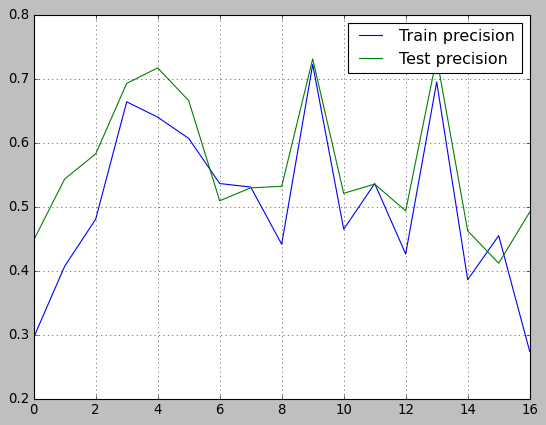

In [ ]:
plt.plot(Train_yhat_metrics_PCA['precision'], label='Train precision')
plt.plot(Test_yhat_metrics_PCA['precision'], label='Test precision')
plt.legend()
plt.grid()
plt.show()

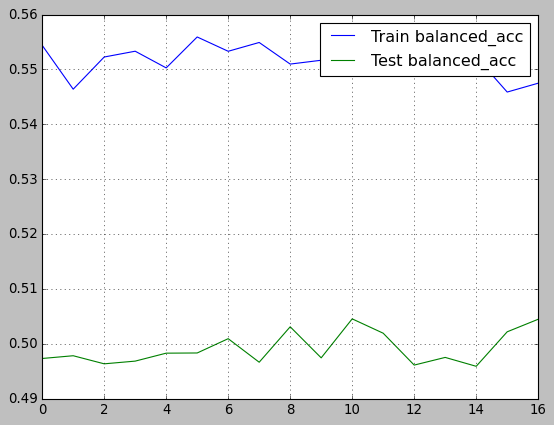

In [ ]:
plt.plot(Train_yhat_metrics_PCA['balanced_acc'], label='Train balanced_acc')
plt.plot(Test_yhat_metrics_PCA['balanced_acc'], label='Test balanced_acc')
plt.legend()
plt.grid()
plt.show()

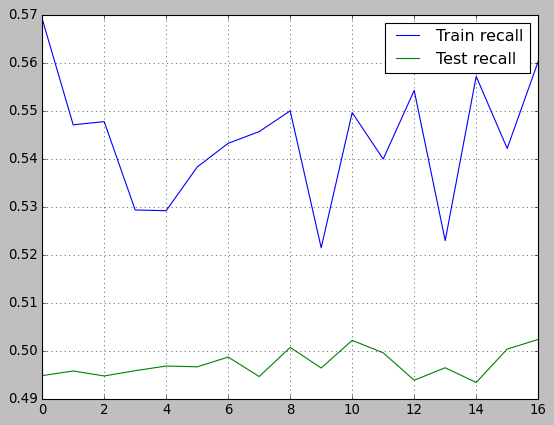

In [ ]:
plt.plot(Train_yhat_metrics_PCA['recall'], label='Train recall')
plt.plot(Test_yhat_metrics_PCA['recall'], label='Test recall')
plt.legend()
plt.grid()
plt.show()

Для PCA наиболее оптимальным показателем стал 8


Epoch 1/20
710/710 [==============================] - 164s 214ms/step - loss: 0.7147 - binary_accuracy: 0.5222 - val_loss: 0.7920 - val_binary_accuracy: 0.5141
Epoch 2/20
710/710 [==============================] - 149s 210ms/step - loss: 0.6894 - binary_accuracy: 0.5449 - val_loss: 0.7702 - val_binary_accuracy: 0.4950
Epoch 3/20
710/710 [==============================] - 149s 210ms/step - loss: 0.6880 - binary_accuracy: 0.5478 - val_loss: 0.7434 - val_binary_accuracy: 0.4970
Epoch 4/20
499/499 [==============================] - 25s 50ms/step
balanced_accuracy: 0.49833562259608755
precision: 0.49645390070921985
recall: 0.6433337529900541


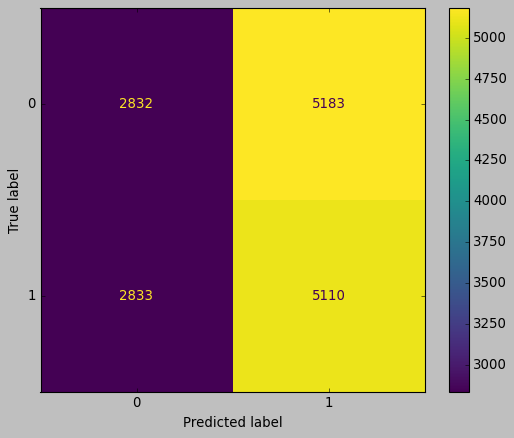

In [ ]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


pca = PCA(n_components=train_X.shape[1]-8)           

Train_X_std_pca = pca.fit_transform(train_X)
Val_X_std_pca = pca.fit_transform(val_X)
Test_X_std_pca = pca.fit_transform(test_X)


Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
Val_X_std_pca = pd.DataFrame(Val_X_std_pca)

n_steps = 10
Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)


train_y_pca = train_y[n_steps - 1: -1]
val_y_pca = val_y[n_steps - 1: -1]
test_y_pca = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_std_pca, train_y_pca, batch_size=72, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_pca)
yhat_test = model.predict(Test_X_std_pca)

yhat_train = model.predict(Train_X_std_pca)
yhat_test = model.predict(Test_X_std_pca)
yhat_train = yhat_train.reshape(yhat_train.shape[0])
yhat_test = yhat_test.reshape(yhat_test.shape[0])

for i in range(len(yhat_train)):
    if (yhat_train[i]>0.5):
        yhat_train[i] = 1
    else:
        yhat_train[i] = 0

for i in range(len(yhat_test)):
    if (yhat_test[i]>0.5):
        yhat_test[i] = 1
    else:
        yhat_test[i] = 0

metrics(test_y_pca, yhat_test)

RFE показала себя лучше

# Quantity of candles Selection

In [183]:
train_X.loc[:, rfe.support_]

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [79]:
columns = list(train_X.loc[:, rfe.support_].columns.values)
columns.append('direction')
df = df_candles_supervised.loc[:,columns]
df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,width_open_high,width_open_low,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,color_of_candle,direction
0,7081.5,6416.8625,6409.246444,6458.050,6520.923722,91.315563,322.0,0.0,130.772817,97.026478,33.746339,173.0,126.0,112.0,319.5,173.0,0,1
1,6591.5,6416.8625,6411.340486,6461.410,6523.692310,50.000000,91.5,0.0,107.841463,99.189475,8.651988,-490.0,-408.5,-408.5,-639.0,91.5,0,1
2,6511.5,6416.8625,6412.489521,6462.730,6523.214032,46.096162,37.0,134.0,82.264575,95.804495,-13.539920,-80.0,-42.5,91.5,37.0,-80.0,1,0
3,6583.5,6416.8625,6414.448381,6465.370,6525.578891,47.911338,77.0,9.5,67.031803,90.049957,-23.018154,72.0,44.5,-80.0,-40.0,72.0,0,0
4,6585.0,6416.8625,6416.399051,6467.980,6527.909796,47.665953,162.0,21.5,54.453058,82.930577,-28.477519,1.5,60.0,72.0,157.0,1.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,30197.0,30549.8580,30404.491705,30213.562,30282.956696,42.417948,16.6,17.8,-18.798746,-14.083861,-4.714885,-1.0,19.6,37.3,-15.2,-1.0,1,1
39796,30194.9,30547.1185,30402.406215,30210.386,30279.503492,39.361702,13.0,27.8,-18.748039,-15.016697,-3.731342,-2.1,-11.0,-1.0,-4.6,-2.1,1,0
39797,30240.3,30544.1305,30400.793218,30211.160,30277.966100,38.682766,112.3,1.3,-14.873006,-14.987959,0.114953,45.4,24.4,-2.1,97.2,45.4,0,1
39798,30240.0,30541.5605,30399.193286,30208.060,30276.477234,46.986667,21.8,18.1,-11.691450,-14.328657,2.637207,-0.3,28.6,45.4,-45.1,-0.3,1,1


In [ ]:
df = df_candles_supervised.loc[:,['close','SMA_200','EMA_200','SMA_50','EMA_50','RSI','width_open_low','macd','signal_line','histogram','close_diff','open_diff','high_diff','width_open_close','width_open_high','color_of_candle','direction']]

In [104]:
For_Comparing_candles = pd.DataFrame(np.zeros([4,5]), columns=['precision','recall','accuracy','f1','count_money'])

def Evaluate_candles(n, real,forecast, close):
    For_Comparing_candles.loc[n,'precision']  = round(precision_score(real, forecast),20)
    For_Comparing_candles.loc[n,'recall']   = round(recall_score(real, forecast),20)
    For_Comparing_candles.loc[n,'accuracy'] = round(balanced_accuracy_score(real, forecast), 20)
    For_Comparing_candles.loc[n,'f1']  = round(f1_score(real, forecast),20)
    For_Comparing_candles.loc[n,'count_money']  = round(count_money(real, forecast, close),20)

In [105]:
def build_model(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu', 'tanh'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    BatchNormalization(),
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model

In [106]:
def split_and_normalization(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = list(dataset.columns.values)
    features.remove('direction')
    features.remove('color_of_candle')

    train_norm = train.loc[:, features].values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)
    
    train_categorial = train.loc[:,['color_of_candle','direction']].reset_index()
    train_std = pd.concat([train_norm, train_categorial], axis=1)
    
    
    # test

    test_norm = test.loc[:, features].values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    
    test_categorial = test.loc[:,['color_of_candle','direction']].reset_index()
    test_std = pd.concat([test_norm, test_categorial], axis=1)
    
    
    # val
    val_norm = val.loc[:, features].values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)
    
    
    val_categorial = val.loc[:,['color_of_candle','direction']].reset_index()
    val_std = pd.concat([val_norm, val_categorial], axis=1)



    train_X = train_std.drop(['direction', 'index'],axis=1)
    # train_X.index = train_X['date']
    # train_X = train_X.drop(['date'],axis=1)
    train_y = train_std['direction']
    
    test_X = test_std.drop(['direction', 'index'],axis=1)
    # test_X.index = test_X['date']
    # test_X = test_X.drop(['date'],axis=1)
    test_y = test_std['direction']


    val_X = val_std.drop(['direction', 'index'],axis=1)
    # val_X.index = val_X['date']
    # val_X = val_X.drop(['date'],axis=1)
    val_y = val_std['direction']

    return train_X, train_y, test_X, test_y, val_X, val_y

Выберем оптимальное количество свечей в последовательности

In [107]:
close = df_candles_supervised['close'].values[(len(train_X) + len(val_X)):]

3 свечи

Epoch 1/20
708/708 [==============================] - 11s 10ms/step - loss: 0.6814 - binary_accuracy: 0.5496 - val_loss: 0.6931 - val_binary_accuracy: 0.5252
Epoch 2/20
708/708 [==============================] - 6s 9ms/step - loss: 0.6308 - binary_accuracy: 0.6132 - val_loss: 0.7012 - val_binary_accuracy: 0.5130
Epoch 3/20
708/708 [==============================] - 6s 9ms/step - loss: 0.5649 - binary_accuracy: 0.6626 - val_loss: 0.6952 - val_binary_accuracy: 0.5268
Epoch 4/20
708/708 [==============================] - 6s 9ms/step - loss: 0.5043 - binary_accuracy: 0.7019 - val_loss: 0.6962 - val_binary_accuracy: 0.5216
Epoch 5/20
708/708 [==============================] - 6s 9ms/step - loss: 0.4618 - binary_accuracy: 0.7233 - val_loss: 0.6992 - val_binary_accuracy: 0.5288
Epoch 6/20
708/708 [==============================] - 6s 9ms/step - loss: 0.4403 - binary_accuracy: 0.7332 - val_loss: 0.6965 - val_binary_accuracy: 0.5317
Epoch 7/20
708/708 [==============================] - 6s 9ms/s

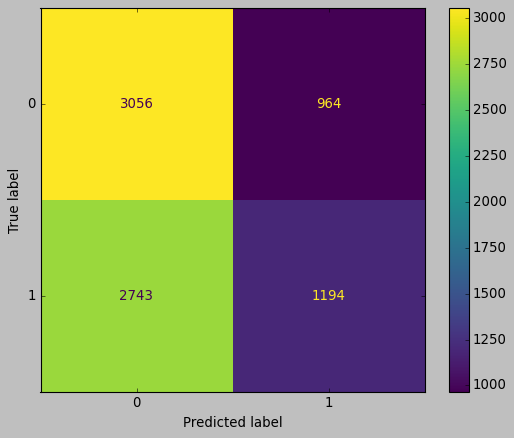

In [108]:
best_models_candle_3 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_3 = model.predict(test_X)
yhat_test_3 = yhat_test_3.reshape(yhat_test_3.shape[0])

for i in range(len(yhat_test_3)):
    if (yhat_test_3[i]>0.5):
        yhat_test_3[i] = 1
    else:
        yhat_test_3[i] = 0


metrics(test_y.values, yhat_test_3)

In [109]:
Evaluate_candles(0, test_y.values, yhat_test_3, close[3:])

5 свечей

Epoch 1/20
708/708 [==============================] - 13s 13ms/step - loss: 0.6799 - binary_accuracy: 0.5458 - val_loss: 0.6975 - val_binary_accuracy: 0.5336
Epoch 2/20
708/708 [==============================] - 8s 12ms/step - loss: 0.6078 - binary_accuracy: 0.6329 - val_loss: 0.6930 - val_binary_accuracy: 0.5378
Epoch 3/20
708/708 [==============================] - 8s 11ms/step - loss: 0.5255 - binary_accuracy: 0.6883 - val_loss: 0.6961 - val_binary_accuracy: 0.5362
Epoch 4/20
708/708 [==============================] - 8s 11ms/step - loss: 0.4647 - binary_accuracy: 0.7199 - val_loss: 0.6982 - val_binary_accuracy: 0.5386
Epoch 5/20
708/708 [==============================] - 8s 11ms/step - loss: 0.4393 - binary_accuracy: 0.7328 - val_loss: 0.7059 - val_binary_accuracy: 0.5375
Epoch 6/20
708/708 [==============================] - 8s 12ms/step - loss: 0.4271 - binary_accuracy: 0.7373 - val_loss: 0.6919 - val_binary_accuracy: 0.5347
Epoch 7/20
249/249 [==============================] - 2s 

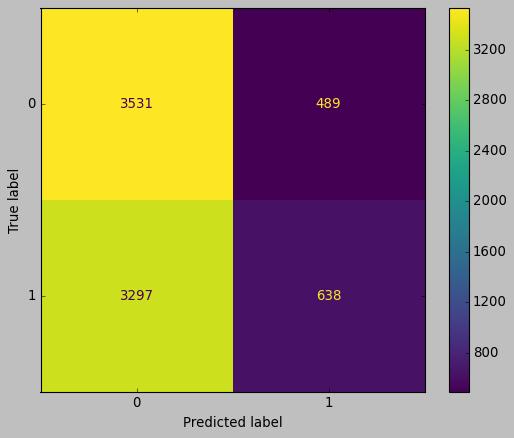

In [111]:
best_models_candle_5 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)



n_steps = 5
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_5 = model.predict(test_X)
yhat_test_5 = yhat_test_5.reshape(yhat_test_5.shape[0])

for i in range(len(yhat_test_5)):
    if (yhat_test_5[i]>0.5):
        yhat_test_5[i] = 1
    else:
        yhat_test_5[i] = 0


metrics(test_y, yhat_test_5)

In [112]:
Evaluate_candles(1, test_y.values, yhat_test_5, close[5:])

10 свечей

Epoch 1/20
708/708 [==============================] - 18s 20ms/step - loss: 0.6857 - binary_accuracy: 0.5342 - val_loss: 0.6933 - val_binary_accuracy: 0.5072
Epoch 2/20
708/708 [==============================] - 14s 20ms/step - loss: 0.6338 - binary_accuracy: 0.6091 - val_loss: 0.7301 - val_binary_accuracy: 0.5220
Epoch 3/20
708/708 [==============================] - 14s 20ms/step - loss: 0.5514 - binary_accuracy: 0.6756 - val_loss: 0.6998 - val_binary_accuracy: 0.5395
Epoch 4/20
708/708 [==============================] - 14s 20ms/step - loss: 0.4814 - binary_accuracy: 0.7135 - val_loss: 0.7139 - val_binary_accuracy: 0.5178
Epoch 5/20
708/708 [==============================] - 14s 20ms/step - loss: 0.4566 - binary_accuracy: 0.7250 - val_loss: 0.6981 - val_binary_accuracy: 0.5173
Epoch 6/20
249/249 [==============================] - 2s 7ms/step
balanced_accuracy: 0.5161397495933906
precision: 0.5061924982307148
recall: 0.7272496187086934
f1-score: 0.5969121635718757


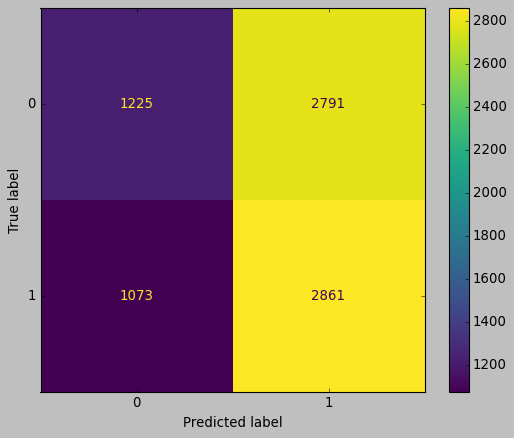

In [113]:
best_models_candle_10 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 10
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_10 = model.predict(test_X)
yhat_test_10 = yhat_test_10.reshape(yhat_test_10.shape[0])

for i in range(len(yhat_test_10)):
    if (yhat_test_10[i]>0.5):
        yhat_test_10[i] = 1
    else:
        yhat_test_10[i] = 0


metrics(test_y.values, yhat_test_10)

In [114]:
Evaluate_candles(2, test_y.values, yhat_test_10, close[10:])

20 свечей

Epoch 1/20
707/707 [==============================] - 26s 34ms/step - loss: 0.6884 - binary_accuracy: 0.5347 - val_loss: 0.6970 - val_binary_accuracy: 0.5143
Epoch 2/20
707/707 [==============================] - 23s 32ms/step - loss: 0.6510 - binary_accuracy: 0.5951 - val_loss: 0.7005 - val_binary_accuracy: 0.5239
Epoch 3/20
707/707 [==============================] - 23s 33ms/step - loss: 0.5862 - binary_accuracy: 0.6499 - val_loss: 0.6917 - val_binary_accuracy: 0.5399
Epoch 4/20
707/707 [==============================] - 23s 32ms/step - loss: 0.5202 - binary_accuracy: 0.6975 - val_loss: 0.7027 - val_binary_accuracy: 0.5318
Epoch 5/20
707/707 [==============================] - 23s 33ms/step - loss: 0.4929 - binary_accuracy: 0.7242 - val_loss: 0.6959 - val_binary_accuracy: 0.5367
Epoch 6/20
249/249 [==============================] - 3s 12ms/step
balanced_accuracy: 0.5231921971520463
precision: 0.5540453074433657
recall: 0.21803362200713194
f1-score: 0.312922683238896


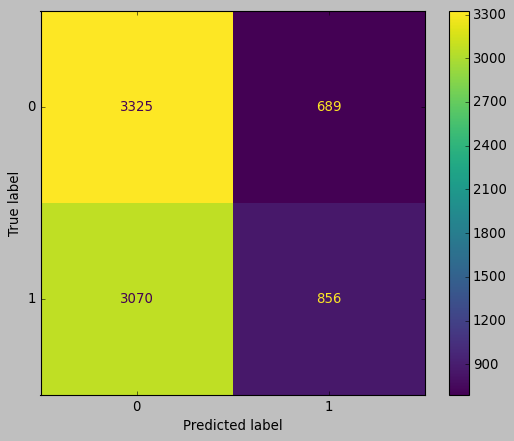

In [115]:
best_models_candle_20 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 20
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_20 = model.predict(test_X)
yhat_test_20 = yhat_test_20.reshape(yhat_test_20.shape[0])

for i in range(len(yhat_test_20)):
    if (yhat_test_20[i]>0.5):
        yhat_test_20[i] = 1
    else:
        yhat_test_20[i] = 0


metrics(test_y.values, yhat_test_20)

In [116]:
Evaluate_candles(3, test_y.values, yhat_test_20, close[20:])

In [117]:
Table_of_Comapring_candles = For_Comparing_candles.copy()
Table_of_Comapring_candles.index = ['3','5','10','20']
Table_of_Comapring_candles

,precision,recall,accuracy,f1,count_money
3,0.553290,0.303277,0.531738,0.391797,41907.7
5,0.566105,0.162135,0.520246,0.252074,27617.9
10,0.506192,0.727250,0.516140,0.596912,12631.4
20,0.554045,0.218034,0.523192,0.312923,34637.5


In [120]:
money = {}
j = 0 
interval = 24 * 7
close = df_candles_supervised['close'].values[(len(train_X) + len(val_X) + 20):]
for i in range(len(test_y_rfe) // interval):
    count_money_100 = count_money(test_y.values[j:j+interval], yhat_test_20[j:j+interval], close[j:j+interval])
    money[i] = count_money_100
    j = j + interval
    print(i,' : ',count_money_100)

0  :  1113.0
1  :  1677.5
2  :  -1709.5
3  :  1584.0
4  :  1259.0
5  :  -98.0
6  :  1012.5
7  :  -805.0
8  :  807.5
9  :  -843.0
10  :  -440.5
11  :  1190.0
12  :  256.0
13  :  -411.5
14  :  1351.5
15  :  -366.5
16  :  -731.5
17  :  -648.5
18  :  1473.0
19  :  223.5
20  :  497.0
21  :  328.5
22  :  2562.5
23  :  2816.5
24  :  -1991.5
25  :  290.0
26  :  1884.3000000000138
27  :  1081.799999999981
28  :  69.19999999998254
29  :  1986.799999999981
30  :  -1307.7000000000007
31  :  5851.600000000006
32  :  862.9999999999745
33  :  1223.6999999999935
34  :  899.5000000000255
35  :  -562.1999999999935
36  :  -2969.1000000000276
37  :  4295.4000000000015
38  :  287.5999999999949
39  :  957.6999999999935
40  :  -26.099999999980355
41  :  836.5999999999949
42  :  -1625.0999999999985
43  :  312.59999999998035
44  :  -539.199999999968
45  :  1523.8000000000065
46  :  343.8000000000029


3

# NN selection

Выбор наилучшего архитектуры

In [137]:
For_Comparing_NN = pd.DataFrame(np.zeros([5,5]), columns=['precision','recall','accuracy','f1','count_money'])

def Evaluate_NN(n, real,forecast, close):
    For_Comparing_NN.loc[n,'precision']  = round(precision_score(real, forecast),20)
    For_Comparing_NN.loc[n,'recall']   = round(recall_score(real, forecast),20)
    For_Comparing_NN.loc[n,'accuracy'] = round(balanced_accuracy_score(real, forecast), 20)
    For_Comparing_NN.loc[n,'f1']  = round(f1_score(real, forecast),20)
    For_Comparing_NN.loc[n,'count_money']  = round(count_money(real, forecast, close),20)

In [122]:
n_steps = 20

LSTM

Trial 5 Complete [00h 21m 06s]
val_binary_accuracy: 0.5185885429382324

Best val_binary_accuracy So Far: 0.5448960065841675
Total elapsed time: 01h 38m 27s
INFO:tensorflow:Oracle triggered exit
249/249 [==============================] - 12s 46ms/step
balanced_accuracy: 0.5469429970142707
precision: 0.5557749259624877
recall: 0.4302088639836984
f1-score: 0.4849964106245513


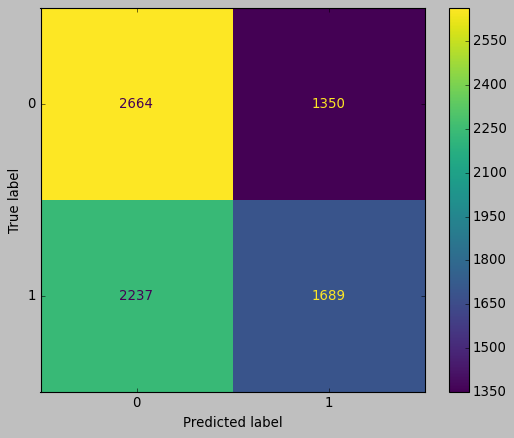

In [125]:
def build_model_LSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTC1HLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_LSTM = best_model_.predict(test_X)
yhat_test_LSTM = yhat_test_LSTM.reshape(yhat_test_LSTM.shape[0])

for i in range(len(yhat_test_LSTM)):
    if (yhat_test_LSTM[i]>0.5):
        yhat_test_LSTM[i] = 1
    else:
        yhat_test_LSTM[i] = 0


metrics(test_y, yhat_test_LSTM)

In [126]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 288)           352512    
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           213504    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 615,489
Trainable params: 615,489
Non-trainable params: 0
_________________________________________________________________


In [138]:
Evaluate_NN(0, test_y.values, yhat_test_LSTM, close[20:])

GRU

Trial 5 Complete [00h 18m 10s]
val_binary_accuracy: 0.5333963632583618

Best val_binary_accuracy So Far: 0.5354442596435547
Total elapsed time: 01h 33m 47s
INFO:tensorflow:Oracle triggered exit
249/249 [==============================] - 11s 41ms/step
balanced_accuracy: 0.5405201128703638
precision: 0.5259042033235581
recall: 0.6851757514009169
f1-score: 0.5950669173763964


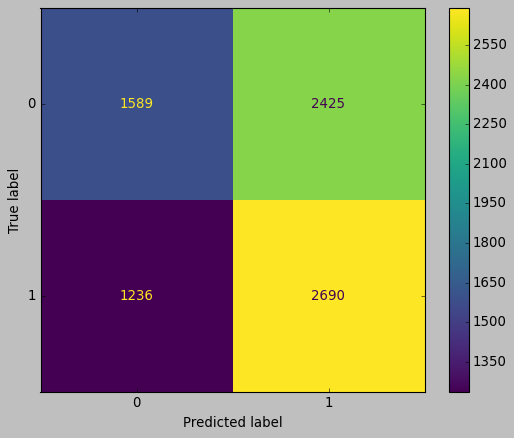

In [129]:
def build_model_GRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_GRU,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTC1HGRU-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_GRU = best_model_.predict(test_X)
yhat_test_GRU = yhat_test_GRU.reshape(yhat_test_GRU.shape[0])

for i in range(len(yhat_test_GRU)):
    if (yhat_test_GRU[i]>0.5):
        yhat_test_GRU[i] = 1
    else:
        yhat_test_GRU[i] = 0


metrics(test_y, yhat_test_GRU)

In [130]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 352)           391776    
                                                                 
 gru_1 (GRU)                 (None, 56)                68880     
                                                                 
 dense (Dense)               (None, 1)                 57        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 460,713
Trainable params: 460,713
Non-trainable params: 0
_________________________________________________________________


In [139]:
Evaluate_NN(1, test_y.values, yhat_test_GRU, close[20:])

BiLSTM

Trial 5 Complete [00h 39m 26s]
val_binary_accuracy: 0.503308117389679

Best val_binary_accuracy So Far: 0.5395399928092957
Total elapsed time: 05h 13m 32s
INFO:tensorflow:Oracle triggered exit
249/249 [==============================] - 37s 141ms/step
balanced_accuracy: 0.5463088182700335
precision: 0.5471752222540867
recall: 0.4859908303616913
f1-score: 0.5147713476325375


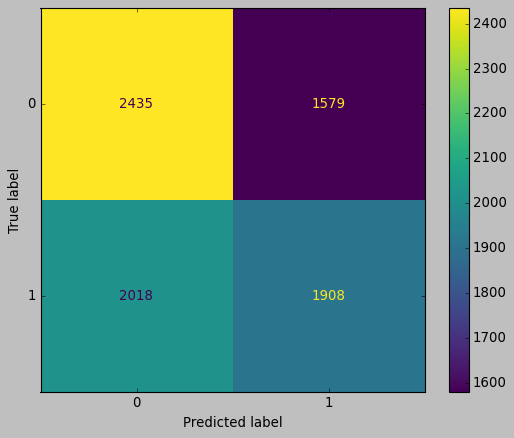

In [132]:
def build_model_BiLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiLSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTC1HBiLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_BiLSTM = best_model_.predict(test_X)
yhat_test_BiLSTM = yhat_test_BiLSTM.reshape(yhat_test_BiLSTM.shape[0])

for i in range(len(yhat_test_BiLSTM)):
    if (yhat_test_BiLSTM[i]>0.5):
        yhat_test_BiLSTM[i] = 1
    else:
        yhat_test_BiLSTM[i] = 0


metrics(test_y, yhat_test_BiLSTM)

In [133]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 512)          561152    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 400)          1140800   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 208)              420160    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 209       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                        

In [140]:
Evaluate_NN(2, test_y.values, yhat_test_BiLSTM, close[20:])

BiGRU

Trial 5 Complete [00h 53m 25s]
val_binary_accuracy: 0.5166981816291809

Best val_binary_accuracy So Far: 0.5420604944229126
Total elapsed time: 04h 14m 05s
INFO:tensorflow:Oracle triggered exit
249/249 [==============================] - 49s 182ms/step
balanced_accuracy: 0.5394459305827465
precision: 0.5560802833530106
recall: 0.3599083036169129
f1-score: 0.4369877841348384


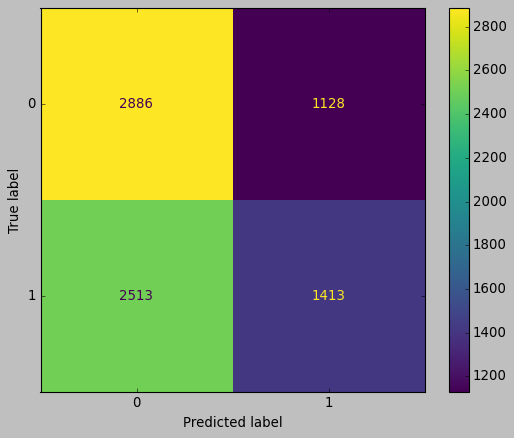

In [145]:
def build_model_BiGRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiGRU,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=5,
                      #seed=123,
                      project_name="BTC1HBiGRU-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=36, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_BiGRU = best_model_.predict(test_X)
yhat_test_BiGRU = yhat_test_BiGRU.reshape(yhat_test_BiGRU.shape[0])

for i in range(len(yhat_test_BiGRU)):
    if (yhat_test_BiGRU[i]>0.5):
        yhat_test_BiGRU[i] = 1
    else:
        yhat_test_BiGRU[i] = 0


metrics(test_y, yhat_test_BiGRU)

In [146]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 688)          749232    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          628224    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 256)          296448    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 256)          296448    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 240)              2

In [147]:
Evaluate_NN(3, test_y.values, yhat_test_BiGRU, close[20:])

Conv-LSTM

In [241]:
def build_model_ConvLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(ConvLSTM2D(input_shape=(1, 1, train_X.shape[3], train_X.shape[4]),
                            activation=activation_choice, filters=32, padding='same', kernel_size=(1,5)))
    
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)

train_X = train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1],train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1],test_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], 1, 1, val_X.shape[1],val_X.shape[2]))

print(train_X.shape)

train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]

from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_ConvLSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=2,
                      #seed=123,
                      project_name="BTC1HCONVLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_CONVLSTM = best_model_.predict(test_X)
yhat_test_CONVLSTM = yhat_test_CONVLSTM.reshape(yhat_test_CONVLSTM.shape[0])

for i in range(len(yhat_test_CONVLSTM)):
    if (yhat_test_CONVLSTM[i]>0.5):
        yhat_test_CONVLSTM[i] = 1
    else:
        yhat_test_CONVLSTM[i] = 0


metrics(test_y, yhat_test_CONVLSTM)

ValueError: list.remove(x): x not in list

In [149]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 20, 32)         31488     
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 32,129
Trainable params: 32,129
Non-trainable params: 0
_________________________________________________________________


In [152]:
Evaluate_NN(4, test_y.values, yhat_test_CONVLSTM, close[20:])

In [153]:
Table_of_Comapring_NN = For_Comparing_NN.copy()
Table_of_Comapring_NN.index = ['LSTM','GRU','BiLSTM','BiGRU','CONV-LSTM']
Table_of_Comapring_NN

,precision,recall,accuracy,f1,count_money
LSTM,0.555775,0.430209,0.546943,0.484996,69125.4
GRU,0.525904,0.685176,0.540520,0.595067,45859.6
BiLSTM,0.547175,0.485991,0.546309,0.514771,67357.4
BiGRU,0.556080,0.359908,0.539446,0.436988,53661.4
CONV-LSTM,0.503315,0.444727,0.507740,0.472211,8561.2


Лучше всего себя показали BiLSTM и BIGRU сети

In [144]:
money = {}
j = 0 
interval = 24 
close = df_candles_supervised['close'].values[(len(train_X) + len(val_X) + 20):]
for i in range(len(test_y_rfe) // interval):
    count_money_100 = count_money(test_y.values[j:j+interval], yhat_test_BiLSTM[j:j+interval], close[j:j+interval])
    money[i] = count_money_100
    j = j + interval
    print(i,' : ',count_money_100)

0  :  602.5
1  :  -87.0
2  :  269.5
3  :  549.0
4  :  1205.5
5  :  -319.5
6  :  350.0
7  :  4.0
8  :  938.5
9  :  79.0
10  :  -117.5
11  :  628.0
12  :  550.0
13  :  -27.0
14  :  687.0
15  :  178.5
16  :  503.5
17  :  82.0
18  :  -101.0
19  :  723.0
20  :  -854.5
21  :  330.0
22  :  223.5
23  :  594.0
24  :  286.5
25  :  193.5
26  :  178.0
27  :  1081.5
28  :  519.0
29  :  800.0
30  :  941.5
31  :  -77.5
32  :  -878.5
33  :  -171.5
34  :  460.0
35  :  229.5
36  :  275.0
37  :  394.0
38  :  -130.0
39  :  -14.5
40  :  923.5
41  :  -335.0
42  :  -207.5
43  :  1125.5
44  :  231.0
45  :  565.5
46  :  -214.5
47  :  -718.0
48  :  -573.0
49  :  72.0
50  :  -48.0
51  :  208.5
52  :  181.5
53  :  -383.5
54  :  752.0
55  :  102.5
56  :  -176.0
57  :  84.5
58  :  589.0
59  :  288.5
60  :  94.0
61  :  382.0
62  :  -330.5
63  :  210.5
64  :  -198.0
65  :  625.5
66  :  -82.0
67  :  50.5
68  :  134.0
69  :  499.0
70  :  29.5
71  :  317.5
72  :  -214.0
73  :  -95.0
74  :  -588.0
75  :  142.5
76  :  498

# CHECK

In [212]:
symbol = 'BTCUSDT'

year = 2023
month = 7
day = 12

### Settings Block End   ###


def get_linenumber():
    cf = currentframe()
    global line_number
    line_number = cf.f_back.f_lineno


def get_bybit_bars(symbol, interval, startTime, endTime):

    url = 'https://api.bybit.com/public/linear/kline'
    startTime = str(int(startTime.timestamp()))
    endTime   = str(int(endTime.timestamp()))
    req_params = {'symbol' : symbol, 'interval' : interval, 'from' : startTime, 'to' : endTime}
    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text)['result'])
    if (len(df.index) == 0):
        return None
    
    df.index = [dt.datetime.fromtimestamp(x) for x in df.open_time]
    return df


df_list = []
end_time = dt.datetime(year, month, day)
delta = dt.timedelta(hours=200)
start_time = end_time - delta

for i in range(2):
    new_df = get_bybit_bars(symbol, 60, start_time, end_time)
    df_list = [new_df] + df_list
    end_time = start_time
    start_time = end_time - delta 
    
df = pd.concat(df_list)
check_df = df[['open','high','low','close']]
print(check_df)

                        open     high      low    close
2023-06-25 08:00:00  30742.7  31042.1  30742.7  30883.3
2023-06-25 09:00:00  30883.3  30931.0  30822.2  30848.8
2023-06-25 10:00:00  30848.8  30987.9  30750.0  30861.3
2023-06-25 11:00:00  30861.3  30869.8  30656.0  30722.3
2023-06-25 12:00:00  30722.3  30757.4  30656.8  30730.0
...                      ...      ...      ...      ...
2023-07-11 12:00:00  30525.1  30552.3  30480.0  30480.1
2023-07-11 13:00:00  30480.1  30496.8  30315.3  30434.3
2023-07-11 14:00:00  30434.3  30435.5  30352.0  30385.3
2023-07-11 15:00:00  30385.3  30445.4  30375.6  30392.7
2023-07-11 16:00:00  30392.7  30408.1  30361.2  30408.1

[393 rows x 4 columns]


In [213]:
columns = {}
columns['close'] = list(OHLCV['close'].values)

SMA и EMA

In [214]:
SMA_200 = check_df['close'].rolling(window = 200).mean()
EMA_200 = check_df['close'].ewm(span=200).mean()
SMA_50 = check_df['close'].rolling(window = 50).mean()
EMA_50 = check_df['close'].ewm(span=50).mean()

SMA_200 = SMA_200.dropna()
EMA_200 = EMA_200.dropna()
SMA_50 = SMA_50.dropna()
EMA_50 = EMA_50.dropna()

columns['SMA_200'] = list(SMA_200.values)
columns['EMA_200'] = list(EMA_200.values)
columns['SMA_50'] = list(SMA_50.values)
columns['EMA_50'] = list(EMA_50.values)

RSI

In [215]:
def calculate_rsi(data, window=14):
    close = data['close']
    delta = close.diff()
    delta = delta[1:]

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window).mean()
    roll_down = np.abs(down.rolling(window).mean())

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

rsi = calculate_rsi(check_df)
rsi = rsi.dropna()
rsi

2023-06-25 22:00:00    21.126026
2023-06-25 23:00:00    21.703039
2023-06-26 00:00:00    18.789249
2023-06-26 01:00:00    31.200867
2023-06-26 02:00:00    34.528570
                         ...    
2023-07-11 12:00:00    48.901587
2023-07-11 13:00:00    35.423626
2023-07-11 14:00:00    35.680967
2023-07-11 15:00:00    56.201091
2023-07-11 16:00:00    54.501786
Name: close, Length: 379, dtype: float64

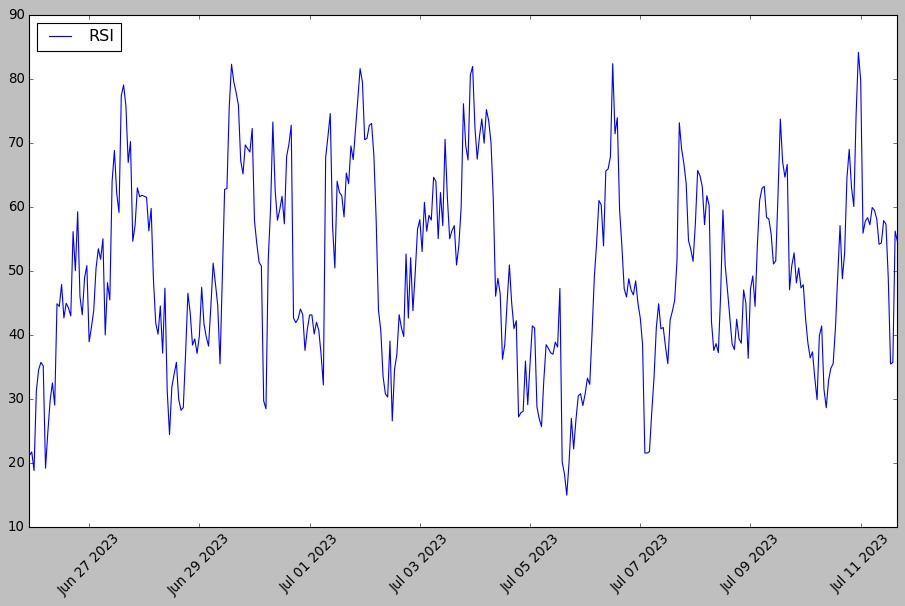

In [216]:
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(rsi, label='RSI', color = 'blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
columns['RSI'] = list(rsi.values)

MACD

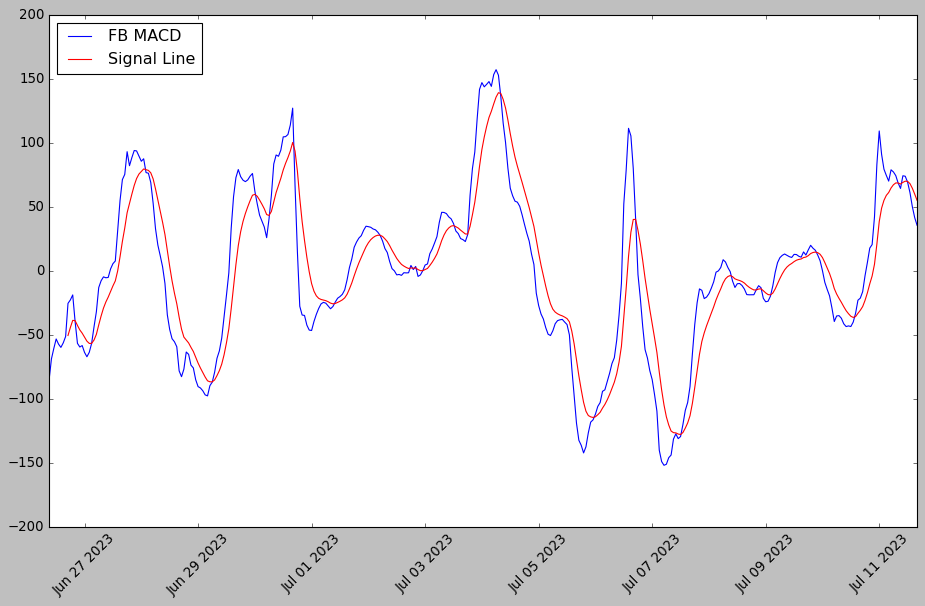

In [217]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    close = data['close']
    exp1 = close.ewm(span=fast, min_periods=fast).mean()
    exp2 = close.ewm(span=slow, min_periods=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

macd, signal_line, histogram = calculate_macd(check_df)

plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(check_df.index, macd, label='FB MACD', color = 'blue')
plt.plot(check_df.index, signal_line, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [218]:
macd = macd.dropna()
signal_line = signal_line.dropna()
histogram = histogram.dropna()

columns['macd'] = list(macd.values)
columns['signal_line'] = list(signal_line.values)
columns['histogram'] = list(histogram.values)

close_diff low_diff open_diff high_diff

In [219]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return diff
# df1 = df[1:]
def difference_for_every_column(df, df1): 
    for column in df.columns.values:
        diff = difference(df[column])
        df1[column+'_diff'] = diff
    return df1

In [220]:
diff_df = pd.DataFrame()
diff_df = difference_for_every_column(check_df[['close', 'low', 'open', 'high']] , diff_df) 
diff_df  

,close_diff,low_diff,open_diff,high_diff
0,-34.5,79.5,140.6,-111.1
1,12.5,-72.2,-34.5,56.9
2,-139.0,-94.0,12.5,-118.1
3,7.7,0.8,-139.0,-112.4
4,-55.2,-75.8,7.7,-27.3
...,...,...,...,...
387,-45.0,-35.0,-90.6,-81.9
388,-45.8,-164.7,-45.0,-55.5
389,-49.0,36.7,-45.8,-61.3
390,7.4,23.6,-49.0,9.9


In [221]:
columns['close_diff'] = list(diff_df['close_diff'].values)
columns['low_diff'] = list(diff_df['low_diff'].values)
columns['open_diff'] = list(diff_df['open_diff'].values)
columns['high_diff'] = list(diff_df['high_diff'].values)

width_open_close, width_open_high, width_open_low

In [222]:
close_values = check_df['close'].values
low_values = check_df['low'].values
open_values = check_df['open'].values
high_values = check_df['high'].values
width_open_close = np.zeros(shape= len(check_df))
width_open_high = np.zeros(shape=len(check_df))
width_open_low = np.zeros(shape=len(check_df))
for i in range(len(check_df)):
    width_open_close[i] = close_values[i] - open_values[i] 
    width_open_high[i] = high_values[i] - open_values[i]
    width_open_low[i] = open_values[i] - low_values[i]

columns['width_open_close'] = list(width_open_close)
columns['width_open_high'] = list(width_open_high)
columns['width_open_low'] = list(width_open_low)

color_of_candle, number_candle_trend

In [224]:
color_of_candle = []
number_candle_trend = np.zeros(shape=len(check_df))
for i in range(len(check_df)):
    if width_open_close[i] > 0:
        color_of_candle.append('green')
    else:
        color_of_candle.append('red')
        
number_candle_trend[0] = 1
cnt = 1
for i in range(1,len(check_df)):
    if (color_of_candle[i] == color_of_candle[i - 1]):
        cnt = cnt + 1
        number_candle_trend[i] = cnt
    else:
        cnt = 1
        number_candle_trend[i] = cnt

columns['color_of_candle'] = color_of_candle
columns['number_candle_trend'] = number_candle_trend

Соберем все признаки в один датасет

In [225]:
for key, value in columns.items():
    print(key, " -> ", len(value))

close  ->  40000
SMA_200  ->  194
EMA_200  ->  393
SMA_50  ->  344
EMA_50  ->  393
RSI  ->  379
macd  ->  368
signal_line  ->  360
histogram  ->  360
close_diff  ->  392
low_diff  ->  392
open_diff  ->  392
high_diff  ->  392
width_open_close  ->  393
width_open_high  ->  393
width_open_low  ->  393
color_of_candle  ->  393
number_candle_trend  ->  393


In [226]:
check_df = pd.DataFrame({})
for key, value in columns.items():
    check_df[key] = value[-(len(SMA_200)):]
    
check_df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend
0,30340.0,30466.3805,30496.326540,30566.684,30569.248443,57.053101,25.136460,31.698070,-6.561610,-25.0,29.0,36.6,16.8,-25.0,32.7,30.6,red,1.0
1,30360.2,30465.1675,30497.985350,30570.408,30572.051367,50.892236,24.279355,30.214327,-5.934972,31.1,-62.4,-25.0,-26.6,31.1,31.1,68.0,green,1.0
2,30387.7,30464.0945,30499.548012,30572.776,30574.489323,53.969034,22.812627,28.733987,-5.921360,-6.5,58.4,31.1,41.3,-6.5,41.3,40.7,red,1.0
3,30471.8,30463.3880,30502.073206,30575.992,30580.197320,59.918682,28.247952,28.636780,-0.388828,85.8,34.2,-6.5,61.9,85.8,109.7,0.0,green,1.0
4,30467.4,30465.0550,30508.405266,30586.118,30598.849810,76.100549,58.963967,34.702217,24.261750,335.7,85.8,85.8,429.2,335.7,453.1,0.0,green,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,30194.9,30472.4140,30382.552821,30293.566,30341.617976,48.901587,69.137542,69.806229,-0.668687,-45.0,-35.0,-90.6,-81.9,-45.0,27.2,45.1,red,2.0
190,30240.3,30471.3525,30383.078356,30297.176,30345.252566,35.423626,61.016260,68.048235,-7.031975,-45.8,-164.7,-45.0,-55.5,-45.8,16.7,164.8,red,3.0
191,30240.0,30469.5710,30383.100914,30299.058,30346.823054,35.680967,50.049258,64.448440,-14.399182,-49.0,36.7,-45.8,-61.3,-49.0,1.2,82.3,red,4.0
192,30187.9,30467.8590,30383.198360,30301.558,30348.622150,56.201091,41.476829,59.854117,-18.377288,7.4,23.6,-49.0,9.9,7.4,60.1,9.7,green,1.0


In [227]:
percent = []
for index, row in check_df.iterrows():
    percent.append(abs(row['close_diff'])/row['close'])

change_percent_mean = np.array(percent).mean()

In [228]:
#делаем сдвиг по целевой переменной, чтобы для каждой строки целевой переменной стало значения закрытия цены на следующей свече
check_df_next = check_df['close'][1:].values
check_df = check_df[:-1]
check_df['close_next'] = check_df_next
check_df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
0,30340.0,30466.3805,30496.326540,30566.684,30569.248443,57.053101,25.136460,31.698070,-6.561610,-25.0,29.0,36.6,16.8,-25.0,32.7,30.6,red,1.0,30360.2
1,30360.2,30465.1675,30497.985350,30570.408,30572.051367,50.892236,24.279355,30.214327,-5.934972,31.1,-62.4,-25.0,-26.6,31.1,31.1,68.0,green,1.0,30387.7
2,30387.7,30464.0945,30499.548012,30572.776,30574.489323,53.969034,22.812627,28.733987,-5.921360,-6.5,58.4,31.1,41.3,-6.5,41.3,40.7,red,1.0,30471.8
3,30471.8,30463.3880,30502.073206,30575.992,30580.197320,59.918682,28.247952,28.636780,-0.388828,85.8,34.2,-6.5,61.9,85.8,109.7,0.0,green,1.0,30467.4
4,30467.4,30465.0550,30508.405266,30586.118,30598.849810,76.100549,58.963967,34.702217,24.261750,335.7,85.8,85.8,429.2,335.7,453.1,0.0,green,2.0,30465.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,30197.0,30473.1500,30381.551776,30288.954,30335.965648,57.273801,73.834341,69.973401,3.860940,-90.6,79.0,174.0,-13.4,-90.6,18.5,100.7,red,1.0,30194.9
189,30194.9,30472.4140,30382.552821,30293.566,30341.617976,48.901587,69.137542,69.806229,-0.668687,-45.0,-35.0,-90.6,-81.9,-45.0,27.2,45.1,red,2.0,30240.3
190,30240.3,30471.3525,30383.078356,30297.176,30345.252566,35.423626,61.016260,68.048235,-7.031975,-45.8,-164.7,-45.0,-55.5,-45.8,16.7,164.8,red,3.0,30240.0
191,30240.0,30469.5710,30383.100914,30299.058,30346.823054,35.680967,50.049258,64.448440,-14.399182,-49.0,36.7,-45.8,-61.3,-49.0,1.2,82.3,red,4.0,30187.9


In [229]:
check_df_supervised = check_df.copy()
directions = []
for index, row in check_df_supervised.iterrows():
    if row['close_next'] > row['close']:
        directions.append('long')
    else:
        directions.append('short')
check_df_supervised['direction'] = directions
check_df_supervised  

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next,direction
0,30340.0,30466.3805,30496.326540,30566.684,30569.248443,57.053101,25.136460,31.698070,-6.561610,-25.0,29.0,36.6,16.8,-25.0,32.7,30.6,red,1.0,30360.2,long
1,30360.2,30465.1675,30497.985350,30570.408,30572.051367,50.892236,24.279355,30.214327,-5.934972,31.1,-62.4,-25.0,-26.6,31.1,31.1,68.0,green,1.0,30387.7,long
2,30387.7,30464.0945,30499.548012,30572.776,30574.489323,53.969034,22.812627,28.733987,-5.921360,-6.5,58.4,31.1,41.3,-6.5,41.3,40.7,red,1.0,30471.8,long
3,30471.8,30463.3880,30502.073206,30575.992,30580.197320,59.918682,28.247952,28.636780,-0.388828,85.8,34.2,-6.5,61.9,85.8,109.7,0.0,green,1.0,30467.4,short
4,30467.4,30465.0550,30508.405266,30586.118,30598.849810,76.100549,58.963967,34.702217,24.261750,335.7,85.8,85.8,429.2,335.7,453.1,0.0,green,2.0,30465.5,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,30197.0,30473.1500,30381.551776,30288.954,30335.965648,57.273801,73.834341,69.973401,3.860940,-90.6,79.0,174.0,-13.4,-90.6,18.5,100.7,red,1.0,30194.9,short
189,30194.9,30472.4140,30382.552821,30293.566,30341.617976,48.901587,69.137542,69.806229,-0.668687,-45.0,-35.0,-90.6,-81.9,-45.0,27.2,45.1,red,2.0,30240.3,long
190,30240.3,30471.3525,30383.078356,30297.176,30345.252566,35.423626,61.016260,68.048235,-7.031975,-45.8,-164.7,-45.0,-55.5,-45.8,16.7,164.8,red,3.0,30240.0,short
191,30240.0,30469.5710,30383.100914,30299.058,30346.823054,35.680967,50.049258,64.448440,-14.399182,-49.0,36.7,-45.8,-61.3,-49.0,1.2,82.3,red,4.0,30187.9,short


Кодируем категориальные переменнные

In [230]:


number_candle_trend_encoder = LabelEncoder()
check_df_supervised["color_of_candle"] = number_candle_trend_encoder.fit_transform(check_df_supervised["color_of_candle"])
color_of_candle_encoder = LabelEncoder()
check_df_supervised["number_candle_trend"] = color_of_candle_encoder.fit_transform(check_df_supervised["number_candle_trend"])
direction_encoder = LabelEncoder()
check_df_supervised["direction"] = direction_encoder.fit_transform(check_df_supervised["direction"])

check_df_supervised.drop(columns = ['close_next'], inplace = True)

In [231]:
check_df_supervised['direction'].value_counts()

1    102
0     91
Name: direction, dtype: int64

In [232]:
check_df_supervised

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,direction
0,30340.0,30466.3805,30496.326540,30566.684,30569.248443,57.053101,25.136460,31.698070,-6.561610,-25.0,29.0,36.6,16.8,-25.0,32.7,30.6,1,0,0
1,30360.2,30465.1675,30497.985350,30570.408,30572.051367,50.892236,24.279355,30.214327,-5.934972,31.1,-62.4,-25.0,-26.6,31.1,31.1,68.0,0,0,0
2,30387.7,30464.0945,30499.548012,30572.776,30574.489323,53.969034,22.812627,28.733987,-5.921360,-6.5,58.4,31.1,41.3,-6.5,41.3,40.7,1,0,0
3,30471.8,30463.3880,30502.073206,30575.992,30580.197320,59.918682,28.247952,28.636780,-0.388828,85.8,34.2,-6.5,61.9,85.8,109.7,0.0,0,0,1
4,30467.4,30465.0550,30508.405266,30586.118,30598.849810,76.100549,58.963967,34.702217,24.261750,335.7,85.8,85.8,429.2,335.7,453.1,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,30197.0,30473.1500,30381.551776,30288.954,30335.965648,57.273801,73.834341,69.973401,3.860940,-90.6,79.0,174.0,-13.4,-90.6,18.5,100.7,1,0,1
189,30194.9,30472.4140,30382.552821,30293.566,30341.617976,48.901587,69.137542,69.806229,-0.668687,-45.0,-35.0,-90.6,-81.9,-45.0,27.2,45.1,1,1,0
190,30240.3,30471.3525,30383.078356,30297.176,30345.252566,35.423626,61.016260,68.048235,-7.031975,-45.8,-164.7,-45.0,-55.5,-45.8,16.7,164.8,1,2,1
191,30240.0,30469.5710,30383.100914,30299.058,30346.823054,35.680967,50.049258,64.448440,-14.399182,-49.0,36.7,-45.8,-61.3,-49.0,1.2,82.3,1,3,1


In [234]:
columns = list(train_X.loc[:, rfe.support_].columns.values)
columns.append('direction')
check_df = check_df_supervised.loc[:,columns]
check_df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,width_open_high,width_open_low,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,color_of_candle,direction
0,30340.0,30466.3805,30496.326540,30566.684,30569.248443,57.053101,32.7,30.6,25.136460,31.698070,-6.561610,-25.0,29.0,36.6,16.8,-25.0,1,0
1,30360.2,30465.1675,30497.985350,30570.408,30572.051367,50.892236,31.1,68.0,24.279355,30.214327,-5.934972,31.1,-62.4,-25.0,-26.6,31.1,0,0
2,30387.7,30464.0945,30499.548012,30572.776,30574.489323,53.969034,41.3,40.7,22.812627,28.733987,-5.921360,-6.5,58.4,31.1,41.3,-6.5,1,0
3,30471.8,30463.3880,30502.073206,30575.992,30580.197320,59.918682,109.7,0.0,28.247952,28.636780,-0.388828,85.8,34.2,-6.5,61.9,85.8,0,1
4,30467.4,30465.0550,30508.405266,30586.118,30598.849810,76.100549,453.1,0.0,58.963967,34.702217,24.261750,335.7,85.8,85.8,429.2,335.7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,30197.0,30473.1500,30381.551776,30288.954,30335.965648,57.273801,18.5,100.7,73.834341,69.973401,3.860940,-90.6,79.0,174.0,-13.4,-90.6,1,1
189,30194.9,30472.4140,30382.552821,30293.566,30341.617976,48.901587,27.2,45.1,69.137542,69.806229,-0.668687,-45.0,-35.0,-90.6,-81.9,-45.0,1,0
190,30240.3,30471.3525,30383.078356,30297.176,30345.252566,35.423626,16.7,164.8,61.016260,68.048235,-7.031975,-45.8,-164.7,-45.0,-55.5,-45.8,1,1
191,30240.0,30469.5710,30383.100914,30299.058,30346.823054,35.680967,1.2,82.3,50.049258,64.448440,-14.399182,-49.0,36.7,-45.8,-61.3,-49.0,1,1


In [238]:


features = list(check_df.columns.values)
features.remove('direction')
features.remove('color_of_candle')               

test_norm = check_df.loc[:, features].values
mean, scale = scaler.mean_, scaler.scale_

for i in range(len(test_norm)):
    for j in range(test_norm.shape[1]):
        test_norm[i][j] = (test_norm[i][j] - mean[j])/scale[j]

test_norm = pd.DataFrame(test_norm, columns=features)

test_categorial = test.loc[:,['color_of_candle','direction']].reset_index()
test_std = pd.concat([test_norm, test_categorial], axis=1)
test_X = test_std.drop(['direction', 'index'],axis=1)
# test_X.index = test_X['date']
# test_X = test_X.drop(['date'],axis=1)
test_y = test_std['direction']

yhat_test_LSTM_check = best_model_.predict(test_X)
yhat_test_LSTM_check = yhat_test_LSTM.reshape(yhat_test_LSTM_check.shape[0])

for i in range(len(yhat_test_LSTM)):
    if (yhat_test_LSTM_check[i]>0.5):
        yhat_test_LSTM_check[i] = 1
    else:
        yhat_test_LSTM_check[i] = 0


metrics(test_y, yhat_test_LSTM_check)

AttributeError: 'StandardScaler' object has no attribute 'mean_'

In [240]:
print(scaler.mean_[0], scaler.scale_[0])

AttributeError: 'StandardScaler' object has no attribute 'mean_'

In [ ]:


yhat_test_CONVLSTM = best_model_.predict(test_X)
yhat_test_CONVLSTM = yhat_test_CONVLSTM.reshape(yhat_test_CONVLSTM.shape[0])

for i in range(len(yhat_test_CONVLSTM)):
    if (yhat_test_CONVLSTM[i]>0.5):
        yhat_test_CONVLSTM[i] = 1
    else:
        yhat_test_CONVLSTM[i] = 0


metrics(test_y, yhat_test_CONVLSTM)